# <center> Exercício Empírico I </center>
## <center> Econometria I - EAE0324 </center>
### <center> Maio 2022 </center>

<!--
---
"lang": "pt-br",
"title": "Exercício Empírico I",
"subtitle": "Econometria I - EAE0324",
"authors": ["Vitor Baldoino - 11766857"],
"date": "Maio 2022"
---
-->
***

> Com o banco de dados do questionário você deve estimar alguns modelos para explicar a nota dos alunos em estatística 2. Você deve explicar porque escolheu as variáveis explicativas e qual o sinal esperado para elas. Depois você deve interpretar os resultados obtidos e o grau de ajuste das regressões. Escolha somente variáveis explicativas contínuas porque até agora não sabemos usar outros tipos de variáveis. ***Que tipo de problema pode surgir pela omissão da(s) variável(eis) que não  é (são) contínua(s)?***
> 
> Como estamos começando agora a estudar inferência, obviamente vocês não precisam se preocupar em verificar a significância estatística dos resultados.
> 
> O trabalho deve ter no máximo 3 páginas. ***A entrega será no até o dia 24/05/22 às 11hs***.

In [76]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm


sns.set_palette('crest')
plt.style.use(['seaborn-paper'])
pd.set_option('display.max_columns', 8)

In [77]:
df = pd.read_csv("data/raw/exercicio-empirico-01.csv")

df_display = df[['genero', 'idade', 'nota1', 'nota2', 'fuvest', 'gosta_curso', 'frequencia']]

***

## Descrição dos Dados

Os dados para este exercício são uma *cross-section* de alunos do curso de Economia da Universidade de São Paulo. Na nossa base de dados, nós temos acesso as seguintes variáveis:

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   genero            45 non-null     object 
 1   idade             45 non-null     int64  
 2   nota1             45 non-null     float64
 3   nota2             45 non-null     float64
 4   fuvest            44 non-null     float64
 5   gosta_curso       45 non-null     object 
 6   frequencia        45 non-null     object 
 7   gosta_estudo      45 non-null     object 
 8   ensino_medio      45 non-null     object 
 9   trabalho          45 non-null     object 
 10  nasceu_sp         45 non-null     object 
 11  pretende_estudar  45 non-null     object 
dtypes: float64(3), int64(1), object(8)
memory usage: 4.3+ KB


Como indicado na tabela acima, nós possuímos uma observação faltante na variável que apresenta a nota da Fuvest. Essa ausência será tratada posteriormente no código que gera os modelos de regressão. Adicionalmente, como não iremos usar variáveis categóricas neste primeiro momento, eu optei por manter na base apenas as variáveis relevantes para o exercício.

In [79]:
df_display.head()

,genero,idade,nota1,nota2,fuvest,gosta_curso,frequencia
0,M,23,8.5,8.5,67.0,S,S
1,M,21,10.0,10.0,71.0,S,S
2,F,21,8.6,8.3,66.0,S,S
3,M,23,9.0,6.8,62.0,S,S
4,M,22,9.5,8.6,68.0,S,S


Abaixo, temos uma breve descrição das variáveis contínuas presentes na base. Como é possível ver, a nota em MAE0229 dos alunos é bem distribuída, assemelhando-se a uma normal. Entretanto, a variável de idade possui uma assimetria à direita, algo esperado dado as características dos indivíduos da amostra (estudantes universitários). E as notas de MAE0219 e as notas da Fuvest possuem uma assimetria à esquerda.

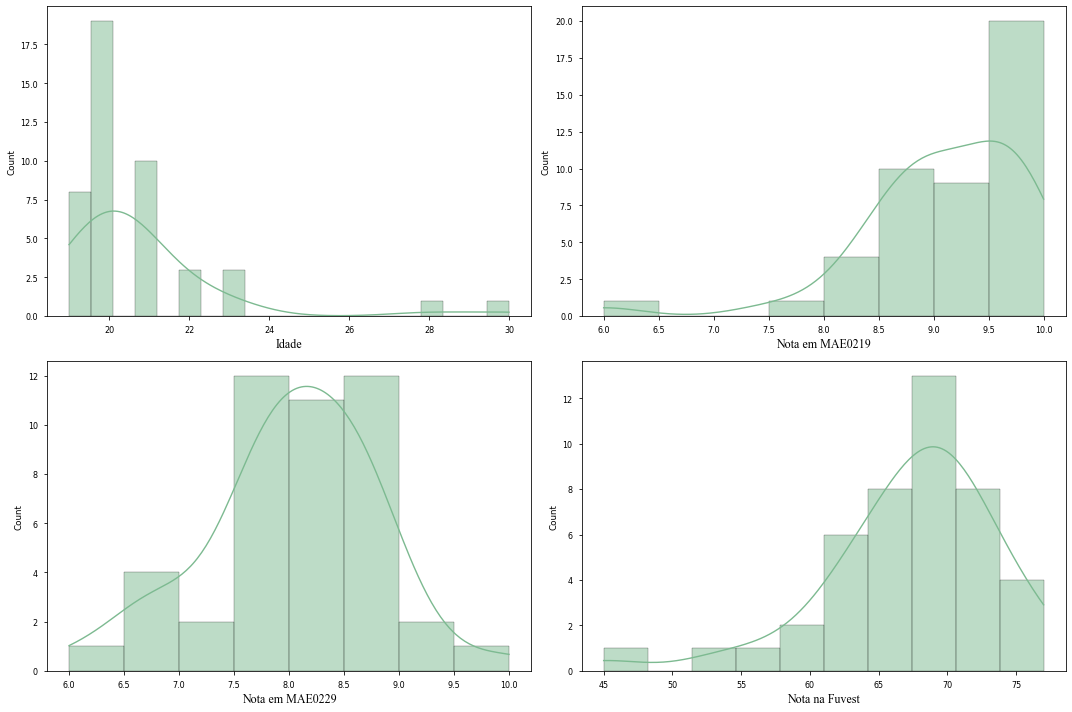

In [81]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.histplot(x='idade', data=df, kde=True, ax=axes[0, 0])
axes[0, 0].set_xlabel('Idade', {'fontname':'Times New Roman', 'fontsize': 12})

sns.histplot(x='nota1', data=df, kde=True, ax=axes[0, 1])
axes[0, 1].set_xlabel('Nota em MAE0219', {'fontname':'Times New Roman', 'fontsize': 12})

sns.histplot(x='nota2', data=df, kde=True, ax=axes[1, 0])
axes[1, 0].set_xlabel('Nota em MAE0229', {'fontname':'Times New Roman', 'fontsize': 12})

sns.histplot(x='fuvest', data=df, kde=True, ax=axes[1, 1])
axes[1, 1].set_xlabel('Nota na Fuvest', {'fontname':'Times New Roman', 'fontsize': 12})

fig.tight_layout()
plt.show()

***

## Modelos de Regressão

Antes de passar para a estimação dos modelos, é necessário retirar o efeito das diferentes escalas de medidas dos dados. Isto é, como as notas das matérias da Universidade de São Paulo são medidas numa escala de 0 a 10 e a prova da Fuvest é medida em uma escala de 0 a 90, precisamos normalizar (trazer para um intervalo entre 0 e 1) os valores dessas variáveis. Terminado o procedimento descrito, a nova base de dados ficará assim:

In [82]:
df_normalized = df.copy(deep=True)

columns = ['nota1', 'nota2', 'fuvest']

for column in columns:
    df_normalized[column] = (df_normalized[column] - df_normalized[column].min()) / (df_normalized[column].max() - df_normalized[column].min())	

df_normalized_display = df_normalized[['genero', 'idade', 'nota1', 'nota2', 'fuvest', 'gosta_curso', 'frequencia']]
df_normalized_display.head()

,genero,idade,nota1,nota2,fuvest,gosta_curso,frequencia
0,M,23,0.625,0.625,0.68750,S,S
1,M,21,1.000,1.000,0.81250,S,S
2,F,21,0.650,0.575,0.65625,S,S
3,M,23,0.750,0.200,0.53125,S,S
4,M,22,0.875,0.650,0.71875,S,S


Posto isso, podemos estimar o modelo:

$$nMAE0229 = \hat{\beta_0} + \hat{\beta_1}nMAE0219 + \hat{u}_i$$ 

Onde $nMAE0229$ é a nota dos alunos em Introdução à Probabilidade e Estatística I e $nMAE0229$ é a nota dos alunos em Introdução à Probabilidade e Estatística II.  

In [83]:
X = df_normalized['nota1']
X = sm.add_constant(X)

Y = df_normalized['nota2']

model = sm.OLS(Y, X, missing='drop')
results = model.fit()
r = results.rsquared

print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                  nota2   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     10.62
Date:                Mon, 23 May 2022   Prob (F-statistic):            0.00219
Time:                        23:12:12   Log-Likelihood:                 15.114
No. Observations:                  45   AIC:                            -26.23
Df Residuals:                      43   BIC:                            -22.61
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1507      0.113      1.339      0.1

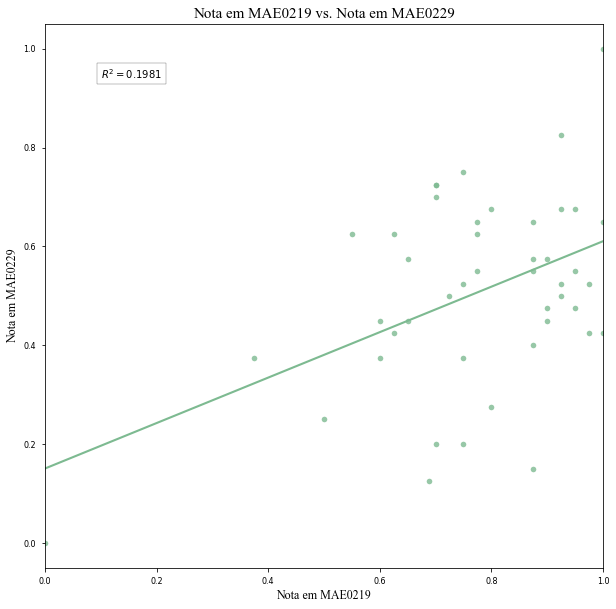

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

sns.regplot(x='nota1', y='nota2', data=df_normalized, ci=None, ax=ax)

ax.set_title("Nota em MAE0219 vs. Nota em MAE0229", {'fontname':'Times New Roman', 'fontsize': 15})
ax.set_ylabel("Nota em MAE0229", {'fontname':'Times New Roman', 'fontsize': 12})
ax.set_xlabel("Nota em MAE0219", {'fontname':'Times New Roman', 'fontsize': 12})

ax.text(0.1, 0.9, fr"$R^2 = {r:.4f}$", transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='black'))

plt.show()

Os resultados da regressão acima dizem que um ponto a mais na nota de Introdução à Probabilidade e Estatística I (MAE0219), está associado a um aumento de $0.4599$ décimos na nota de Introdução à Probabilidade e Estatística II (MAE0229). Esse resultado faz algum sentido lógico, pois é esperado que alunos com mais base se saiam melhores nas matérias que presumem conhecimento prévio.

Entretanto, é necessário notar que o $R^2$ da regressão é de $0.1981$, o que significa que o modelo especificado explica apenas 19% da varição da nota em MAE0229. De fato, houve a omissão de variáveis que podem impactar significativamente o grau de ajuste do modelo, tais como a idade dos alunos e o seu nível de preparação ao sair do ensino médio - medido pela nota da Fuvest. 

Para corrigir o erro de omissão de variável do modelo anterior, estimaremos um novo modelo, dado por:

$$nMAE0229 = \hat{\beta_0} + \hat{\beta_1}nMAE0219 + \hat{\beta_2}nFUVEST + \hat{u}_i$$

Onde as varáveis anteriores mantém seu significado e $nFUVEST$ é a nota dos alunos na última prova da FUVEST que prestaram. 

In [85]:
X = df_normalized[['nota1', 'fuvest']]
X = sm.add_constant(X)

Y = df_normalized['nota2']

model = sm.OLS(Y, X, missing='drop')
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  nota2   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     5.912
Date:                Mon, 23 May 2022   Prob (F-statistic):            0.00555
Time:                        23:12:12   Log-Likelihood:                 15.094
No. Observations:                  44   AIC:                            -24.19
Df Residuals:                      41   BIC:                            -18.83
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0846      0.139      0.611      0.5

Os resultados da regressão acima indicam que, mantendo a nota em MAE0219 constante, um ponto a mais na prova da Fuvest está associado a um aumento de 8,79% na média de MAE0229. Em outras palavras, dados dois estudantes com a mesma nota em MAE0219, a previsão é que o estudante que tiver obtido a maior nota na Fuvest terá uma nota 8,79% maior em MAE0229.

Analogamente, mantendo a nota da Fuvest constante, um aumento na nota de MAE0219 está associado a um aumento de 47% da média de MAE0229.

Entretanto, vale notar que o $R^2$ da regressão ainda é baixo - somente 22% da variação da nota em MAE0229 é explicada pelas variáveis da regressão. Isto é um indicativo de que temos outras variáveis no termo de erro $u_i$ que ajudam a explicar melhor a variação da nota de Introdução à Probabilidade e Estatística II. Em última instância, a omissão dessas variáveis (por exemplo, as variáveis categóricas que possuímos nas bases) podem causar um problema de viés dos estimadores da nossa regressão.
